# Processing simulations

### Workflow:
	- Run PIMD simulations of each polymorph of each compound
		- Use the potentials in NN_potentials to evaluate forces and energies during simulations
	- Convert to ASE file type using the 'convert_ipi_to_ase.py' script
	- Extract random testing and validation configurations, use the rest for training
	- Order the training set via FPS by using the fps_order.py script
	- Construct a distinct model for each compound polymorph using the construct_model.py script
		- Make sure to understand input variables (see questions)
	- Use the "calculate_shieldings.py" script to predict shieldings, using the trajectories as input
    
 PS: You need to set up the appropriate Conda environment using the environment.yml file

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ase, ase.io
import chemiscope

In [23]:
def trajectory_fig(sim_outfile, percent=100):
    '''
    Takes a simulation.out file and produces plots of carious properties over the course of the trajectory.
    NOTE: it is assumed that the simulation.out file contains the columns in the 'header' variable in the same order.
    If this isn't the case, please change the headers line above, and also make sure that the usecols option
    below reflects the number of columns that are present.
    '''
    
    # Get column headers
    headers = []
    with  open(sim_outfile,'r') as cmt_file:    # open file
        for line in cmt_file:    # read each line
            if line[0] == '#':    # check the first character
                line = line[21:]    # remove first '#'
                para = line.split(' :')     # seperate string by ':'
                if len(para) == 2:
                    headers.append(para[0])
    
    # Read simulation file
    sim= pd.read_csv(sim_outfile, sep=' ', skipinitialspace=True, comment='#', usecols=[0,1,2,3,4,5], names=headers)
    
    frames=int(percent*len(sim)/100)
    
    #Create plots
    plotted=sim.iloc[0:frames].plot(kind='line', subplots=True, x='step', figsize=(10,20))
    fig=plotted[0].get_figure()
    
    #Save plot
    fig.savefig('traj_properties.png')
    
    print('Figure saved as traj_properties.png')
          

Figure saved as traj_properties.png


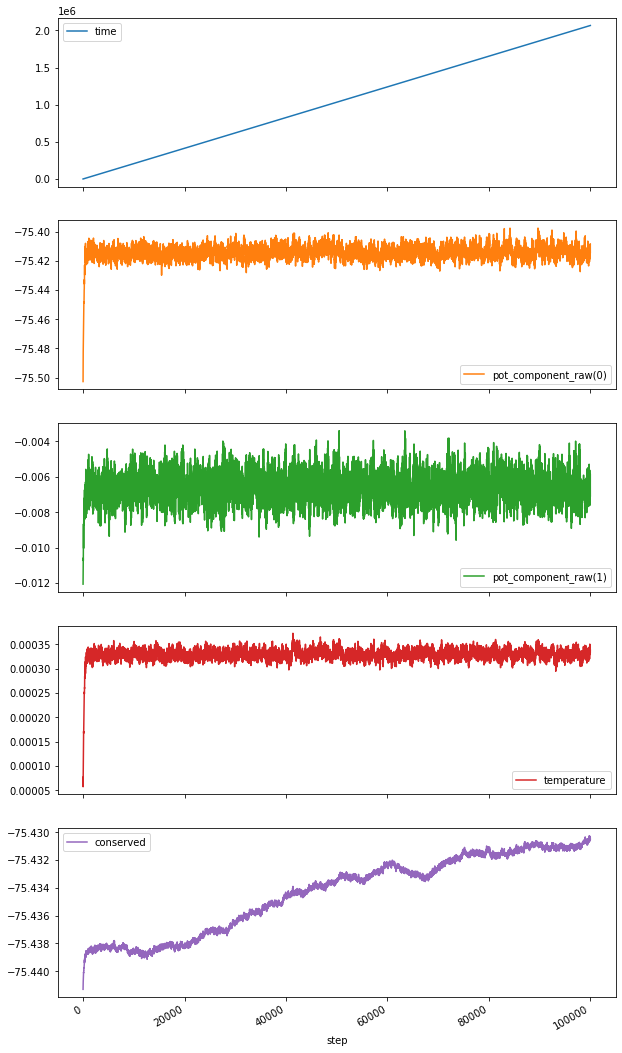

In [24]:
trajectory_fig('sims_examples/simulation.out')

# --------------------------- Ignore for the moment -----------------------------------

### Split and randomise simulation frames
Only 2500 frames were used for training in this instance

In [7]:
frames_00 = ase.io.read('PIMD_examples/PI_NVT/benzene_I/simulation_ase_converted/ase_simulation.pos_00.xyz', index = ':')
print(len(frames_00), flush=True)


10001


In [8]:
#shuffle ids
ids = list(range(len(frames_00)))
np.random.seed(10)
np.random.shuffle(ids)

print(ids[:10])

[937, 9355, 2293, 192, 8675, 53, 9597, 265, 984, 9794]


In [9]:
print(len(ids))

10001


In [7]:
n_train = 2500
n_val = 300
n_test = 300

train_ids = [int(i) for i in ids[:n_train]]
val_ids = [int(i) for i in ids[n_train:(n_train+n_val)]]
test_ids = [int(i) for i in ids[(n_train+n_val):(n_train+n_val+n_test)]]

frames_train = [frames_00[ii] for ii in train_ids]
frames_val = [frames_00[ii] for ii in val_ids]
frames_test = [frames_00[ii] for ii in test_ids]

print('Splitting complete')

Splitting complete


In [8]:
ase.io.write('PIMD_examples/PI_NVT/benzene_I/randomised_frames/benzene_ShiftML_frames_train.xyz', frames_train)
ase.io.write('PIMD_examples/PI_NVT/benzene_I/randomised_frames/benzene_ShiftML_frames_test.xyz', frames_test)
ase.io.write('PIMD_examples/PI_NVT/benzene_I/randomised_frames/benzene_ShiftML_frames_val.xyz', frames_val)

In [42]:
%config Completer.use_jedi = False

# ---------------------------------- Stop Ignoring -------------------------------------

### Discarding equilibration part of simulation

Each simulation was run for 100 000 steps (50 ps). This first 10% of the simulation can be removed using the commands below.

In [6]:
def discard_equilibration(xyz_file, outfile, percentage=5):
    '''
    Takes a simulation.out file and produces plots of carious properties over the course of the trajectory.
    NOTE: it is assumed that the simulation.out file contains the columns in the 'header' variable in the same order.
    If this isn't the case, please change the headers line above, and also make sure that the usecols option
    below reflects the number of columns that are present.
    '''
    #Read xyz file
    sim = ase.io.read(xyz_file, index = ':')
    print('Total number of frames: '+ str(len(sim)))
    
    #Index frames to chuck
    to_chuck= int(len(sim)*(percentage/100))
    print('Discarding first ' + str(percentage) + '% of frames.')
    
    #Remove unwanted frames
    to_use= sim[to_chuck:]
    print('Frames remaining:'+ str(len(to_use)))

    #Write xyz file (second argument passed)
    ase.io.write(outfile, to_use)

    print('File saved as:', str(outfile))


In [8]:
discard_equilibration('sims_examples/ase_simulation.pos_00.xyz', 'sims_examples/benzene_I_100k_no_eq.xyz', percentage=10)

Total number of frames: 10001
Discarding first 10% of frames.
Frames remaining:9001
File saved as: sims_examples/benzene_I_100k_no_eq.xyz


In [35]:
def get_shieldings_and_errors(xyz_file, save_filename):
    '''
    Read an ASE-formatted xyz trajectory, get the chemical shieldings and errors, and save them to a new CSV
    The save_filename is the prefix of the filename to be saved (do not add .csv to this).
    File will be saved as save_filname.csv
    '''
    
    #get number of frames in traj
    all_frames= len(ase.io.read(xyz_file, index=':'))
    print('Frames to read: '+ str(all_frames))
    
    #get array of chemical symbols for columns
    symbols=ase.io.read(xyz_file, index=1).get_chemical_symbols()
    
    #number atoms of each species
    c = 0
    h = 0
    n = 0
    o = 0
    for num in range(len(symbols)):
        if symbols[num] == 'C':
            symbols[num] = symbols[num]+str(c+1)
            c += 1
        elif symbols[num] == 'H':
            symbols[num] = symbols[num]+str(h+1)
            h += 1
        elif symbols[num] == 'N':
            symbols[num] = symbols[num]+str(n+1)
            n += 1
        elif symbols[num] == 'O':
            symbols[num] = symbols[num]+str(o+1)
            o += 1
    
    #create array of column headers for errors
    error_symbols = []
    for symbol in symbols:
        error_symbols.append(symbol + 'err')
    
    print('Atoms per frame: '+ str(len(symbols)))
    
    shieldings_raw=[]
    shielding_errors_raw=[]
    
    atoms=ase.io.read(xyz_file, index=':')
    
    #get chemical shieldings and errors form each frame
    if atoms[0].has('cs_iso')==True:   #check if array is indexed using Matthias's method
        for i in range(len(atoms)):
            cs=atoms[i].get_array('cs_iso')
            shieldings_raw.append(cs)
    else:
        for i in range(len(atoms)):
            cs = atoms[i].get_array('CS')
            cserr = atoms[i].get_array('CSerr')
            shieldings_raw.append(cs)
            shielding_errors_raw.append(cserr)
    
    #create numpy arrays of shieldings and errors
    shieldings=np.array(shieldings_raw)
    shielding_errors=np.array(shielding_errors_raw)
    
    #save shieldings and errors to new CSV
    df_shieldings = pd.DataFrame(shieldings, columns = symbols)
    df_total = df_shieldings
    
    if len(shielding_errors)>0:
        df_errors = pd.DataFrame(shielding_errors, columns = error_symbols)
        for column in df_errors.columns:
            df_total[column] = df_errors[column]
    
    df_total.to_csv(save_filename+'.csv')
    print('Shieldings and errors saved as: '+save_filename+'.csv')

In [36]:
get_shieldings_and_errors('sims_examples/example_frames_w_cs.xyz', 'sims_examples/shieldings_example')

Frames to read: 300
Atoms per frame: 24
Shieldings and errors saved as: sims_examples/shieldings_example.csv


### Go to the plot_shieldings notebook to process shieldings.csv for plotting.

In [37]:
get_shieldings_and_errors('../besmd_genshield/test/bII_noeq_w_cs.xyz', '../besmd_genshield/test/bII_shieldings')

Frames to read: 9501
Atoms per frame: 24
Shieldings and errors saved as: ../besmd_genshield/test/bII_shieldings.csv
